## 1. Подключение библиотек и импорт данных

In [70]:
pip install pymorphy3

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.dates import DateFormatter

In [72]:
import pandas as pd
import numpy as np

In [73]:
df = pd.read_csv(r"C:\Users\valem\Documents\Gamer Site\real_estate_data.csv", low_memory=False)

### Описание набора данных

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403487 entries, 0 to 403486
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 403487 non-null  int64  
 1   type               403487 non-null  object 
 2   sub_type           403487 non-null  object 
 3   start_date         403487 non-null  object 
 4   end_date           266298 non-null  object 
 5   listing_type       403487 non-null  int64  
 6   tom                403487 non-null  int64  
 7   building_age       376097 non-null  object 
 8   total_floor_count  375466 non-null  object 
 9   floor_no           368191 non-null  object 
 10  room_count         403487 non-null  object 
 11  size               257481 non-null  float64
 12  address            403487 non-null  object 
 13  furnished          0 non-null       float64
 14  heating_type       375517 non-null  object 
 15  price              402772 non-null  float64
 16  pr

### Признаки (Описание)


##### type (Тип недвижимости) 
##### sub_type (подгруппа по типу недвижимости)
##### start_date (дата, когда листинг начинает действовать на рынке)
##### end_date (дата, когда листинг больше не активен на рынке)
##### listing_type (Тип объявления)
##### tom (Время выхода на рынок)
##### building_age (Возраст здания)
##### total_floor_count (Общее количество этажей в здании)
##### room_count (Количество комнат в квартире)
##### size (Размер дома)
##### address (Адрес жилого помещения)
##### furnished (-)
##### currency (Валюта цены на жилье)
##### floor_no (Информация о номере этажа в данном объявлении)
##### price (Стоимость дома)
##### heating_type (Различные типы систем отопления)

## 2. Предварительная обработка данных

In [75]:
df.duplicated().sum()  

np.int64(0)

In [76]:
df.isna().sum()

id                        0
type                      0
sub_type                  0
start_date                0
end_date             137189
listing_type              0
tom                       0
building_age          27390
total_floor_count     28021
floor_no              35296
room_count                0
size                 146006
address                   0
furnished            403487
heating_type          27970
price                   715
price_currency          715
dtype: int64

## Заполнение датасета средними значениями


In [77]:
df['size'] = df['size'].fillna(df['size'].mean())
df['building_age'] = pd.to_numeric(df['building_age'], errors='coerce')
df['building_age'] = df['building_age'].fillna(df['building_age'].mean())

In [78]:
df.isna().sum()

id                        0
type                      0
sub_type                  0
start_date                0
end_date             137189
listing_type              0
tom                       0
building_age              0
total_floor_count     28021
floor_no              35296
room_count                0
size                      0
address                   0
furnished            403487
heating_type          27970
price                   715
price_currency          715
dtype: int64

In [79]:
df['total_floor_count'].unique()

array(['20 ve üzeri', '1', '10-20 arası', '4', '2', '3', '8', '7', '6',
       '5', '10', nan, '9'], dtype=object)

In [80]:
replacements = {
    ' ve üzeri': '',
    '10-20 arası': '15', 
    '6-10 arası': '8'   
}


for old_text, new_text in replacements.items():
    df['total_floor_count'] = df['total_floor_count'].str.replace(old_text, new_text)


df['total_floor_count'] = df['total_floor_count'].fillna('0').astype(int)

In [81]:
df['total_floor_count'].unique()

array([20,  1, 15,  4,  2,  3,  8,  7,  6,  5, 10,  0,  9])

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403487 entries, 0 to 403486
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 403487 non-null  int64  
 1   type               403487 non-null  object 
 2   sub_type           403487 non-null  object 
 3   start_date         403487 non-null  object 
 4   end_date           266298 non-null  object 
 5   listing_type       403487 non-null  int64  
 6   tom                403487 non-null  int64  
 7   building_age       403487 non-null  float64
 8   total_floor_count  403487 non-null  int64  
 9   floor_no           368191 non-null  object 
 10  room_count         403487 non-null  object 
 11  size               403487 non-null  float64
 12  address            403487 non-null  object 
 13  furnished          0 non-null       float64
 14  heating_type       375517 non-null  object 
 15  price              402772 non-null  float64
 16  pr

## Заполнение пустых значений дат на медианную дату

In [83]:
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')


median_date = df['end_date'].median()
df['end_date'] = df['end_date'].fillna(median_date)

print(f"Заполнено медианной датой: {median_date}")

Заполнено медианной датой: 2018-12-27 00:00:00


## Этажи/пристройки 

In [84]:

floor_replacements = {
    'Kot ': '',           
    ' ve üzeri': '',      
    'Yüksek Giriş': '10',  
    'Asma Kat': '1',       
    'Bahçe katı': '4',    
    'Müstakil': '7',       
    'Zemin Kat': '1',      
    'En Üst Kat': '10',    
    'Giriş Katı': '3',     
    'Çatı Katı': '4',      
    'Teras': '1',         
    'Komple': '6',         
    'Bodrum Kat': '1',     
    ' Kat': ''             
}


if 'floor_no' in df.columns and df['floor_no'].dtype == 'object':
    
    df['floor_no'] = df['floor_no'].astype(str).str.strip()
    
   
    for old_value, new_value in floor_replacements.items():
        df['floor_no'] = df['floor_no'].str.replace(old_value, new_value, regex=False)
    
   
    df['floor_no'] = df['floor_no'].str.replace(r'[^\d\-]', '', regex=True)
    
    
    df['floor_no'] = df['floor_no'].replace('', '0')
    
    
    df['floor_no'] = pd.to_numeric(df['floor_no'], errors='coerce')
    
    
    df['floor_no'] = df['floor_no'].fillna(0).astype(int)
    
    print("Обработка этажей завершена!")
    print(f"Диапазон этажей: от {df['floor_no'].min()} до {df['floor_no'].max()}")
else:
    print("Колонка 'floor_no' не найдена или уже числовая")

Обработка этажей завершена!
Диапазон этажей: от 0 до 20


In [85]:
df['floor_no'].unique()

array([ 2, 20, 10, 14,  0,  1,  4, 11,  3, 13,  7, 16, 19,  5,  8, 15,  9,
       12, 17,  6, 18])

In [86]:
df['heating_type'].unique()

array(['Fancoil', 'Yok', 'Kalorifer (Doğalgaz)', 'Kalorifer (Kömür)',
       'Kombi (Elektrikli)', 'Klima', 'Kombi (Doğalgaz)',
       'Merkezi Sistem (Isı Payı Ölçer)', 'Merkezi Sistem',
       'Soba (Kömür)', 'Yerden Isıtma', 'Soba (Doğalgaz)',
       'Güneş Enerjisi', 'Kalorifer (Akaryakıt)', 'Jeotermal',
       'Kat Kaloriferi', nan], dtype=object)

In [87]:
df['heating_type'] = df['heating_type'].fillna('absent')

In [88]:
df['price'] = df['price'].fillna(df['price'].mean())

In [89]:
df['price'] = df['price'].astype(int)
df['size'] = df['size'].astype(int)
df['building_age'] = df['building_age'].astype(int)

In [90]:
df.isna().sum()

id                        0
type                      0
sub_type                  0
start_date                0
end_date                  0
listing_type              0
tom                       0
building_age              0
total_floor_count         0
floor_no                  0
room_count                0
size                      0
address                   0
furnished            403487
heating_type              0
price                     0
price_currency          715
dtype: int64

# Преобразование валюты в единное целое

In [91]:
df['price_currency'].unique()

array(['TRY', 'GBP', 'EUR', 'USD', nan], dtype=object)

In [92]:
def convert_to_try_currency(dataframe, rates):
    df_copy = dataframe.copy()
    df_copy['price'] = df_copy['price'].astype(float)
    
    currency_conversion = [
        (df_copy['price_currency'] == curr, 
         df_copy['price'] * float(rate), 
         'TRY')
        for curr, rate in rates.items()
    ]
    
    for mask, converted_price, new_currency in currency_conversion:
        df_copy.loc[mask, 'price'] = converted_price
        df_copy.loc[mask, 'price_currency'] = new_currency
    
    return df_copy


valyuta = {'EUR': 95.91, 'USD': 83.24, 'GBP': 112.67}


df = convert_to_try_currency(df, valyuta)

In [93]:

df.drop('furnished', axis=1, inplace=True)
df.drop('price_currency', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.drop('type', axis=1, inplace=True)

In [94]:
df.isna().sum()

sub_type             0
start_date           0
end_date             0
listing_type         0
tom                  0
building_age         0
total_floor_count    0
floor_no             0
room_count           0
size                 0
address              0
heating_type         0
price                0
dtype: int64

In [95]:

df['start_date'] = pd.to_datetime(df['start_date'], format='mixed', dayfirst=True)
df['end_date'] = pd.to_datetime(df['end_date'], format='mixed', dayfirst=True)

In [96]:
df[df['room_count'] == '+'].count()

sub_type             2898
start_date           2898
end_date             2898
listing_type         2898
tom                  2898
building_age         2898
total_floor_count    2898
floor_no             2898
room_count           2898
size                 2898
address              2898
heating_type         2898
price                2898
dtype: int64

In [97]:
def parse_room_quantity(input_value):
    if pd.isna(input_value) or input_value in ['+', ''] or input_value == 0: # не корректные
        return 1
    
    string_value = str(input_value)
    parts = string_value.split('+')
    total_rooms = 0
    for part in parts:
        if part.isdigit():
            total_rooms += int(part)
    if total_rooms == 20:
        return 1
    
    return total_rooms
df['room_count'] = df['room_count'].apply(parse_room_quantity)

In [98]:
df[df['size'] < 20].count().sum()

np.int64(6409)

In [99]:
df[df['price'] < 0].count().sum()

np.int64(13)

In [100]:

indices_to_drop = df[(df['size'] < 20) | (df['price'] < 0)].index
df = df.drop(indices_to_drop)
indices_to_drop = df[(df['price'] > 500000)].index
df = df.drop(indices_to_drop)
indices_to_drop = df[(df['size'] > 6000)].index
df = df.drop(indices_to_drop)
indices_to_drop = df[(df['listing_type'] == 3)].index
df = df.drop(indices_to_drop)

In [101]:
df.describe()

,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,price
count,347083,347083,347083.000000,347083.000000,347083.000000,347083.000000,347083.000000,347083.000000,347083.000000,347083.000000
mean,2018-10-28 22:53:42.318580736,2018-12-23 08:17:02.777837568,1.328550,55.801439,1.050803,5.343543,3.763794,3.531176,174.867680,170068.204302
min,2018-01-09 00:00:00,2018-08-31 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,0.000000
25%,2018-09-15 00:00:00,2018-12-08 00:00:00,1.000000,27.000000,0.000000,3.000000,2.000000,3.000000,95.000000,1750.000000
50%,2018-10-30 00:00:00,2018-12-27 00:00:00,1.000000,36.000000,1.000000,4.000000,3.000000,4.000000,140.000000,175000.000000
75%,2018-12-27 00:00:00,2019-01-13 00:00:00,2.000000,88.000000,1.000000,6.000000,5.000000,4.000000,279.000000,275000.000000
max,2019-12-02 00:00:00,2019-02-27 00:00:00,2.000000,180.000000,5.000000,20.000000,20.000000,14.000000,6000.000000,500000.000000
std,NaN,NaN,0.469687,43.925310,1.223290,4.028169,3.173942,0.982806,101.534245,144518.689772


In [102]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['address_encoded'] = le.fit_transform(df['address'])
df = df.drop('address', axis=1)

In [103]:
df

,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,heating_type,price,address_encoded
0,Rezidans,2018-10-12,2019-01-09,2,30,0,20,2,3,90,Fancoil,3500.0,6301
1,Daire,2019-02-13,2018-12-27,1,14,0,20,20,1,43,Fancoil,490000.0,6301
2,Daire,2018-09-10,2018-11-08,1,30,0,1,10,3,279,Fancoil,155000.0,5314
6,Daire,2019-04-01,2018-12-27,2,54,0,20,14,4,160,Fancoil,3750.0,6301
11,Rezidans,2019-05-01,2019-01-18,2,13,2,20,20,4,165,Fancoil,7500.0,6703
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403480,Daire,2018-09-25,2019-01-23,1,120,1,0,0,4,279,absent,185000.0,1165
403481,Daire,2019-12-01,2018-12-27,1,46,1,0,0,1,279,absent,354641.0,7096
403482,Daire,2018-09-18,2018-12-27,2,162,1,0,0,1,279,absent,1500.0,6477
403483,Daire,2018-11-10,2018-12-27,1,139,1,0,0,3,279,absent,120000.0,4838


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 347083 entries, 0 to 403486
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   sub_type           347083 non-null  object        
 1   start_date         347083 non-null  datetime64[ns]
 2   end_date           347083 non-null  datetime64[ns]
 3   listing_type       347083 non-null  int64         
 4   tom                347083 non-null  int64         
 5   building_age       347083 non-null  int64         
 6   total_floor_count  347083 non-null  int64         
 7   floor_no           347083 non-null  int64         
 8   room_count         347083 non-null  int64         
 9   size               347083 non-null  int64         
 10  heating_type       347083 non-null  object        
 11  price              347083 non-null  float64       
 12  address_encoded    347083 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(8), objec

## 3. Визуальный анализ данных

In [105]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

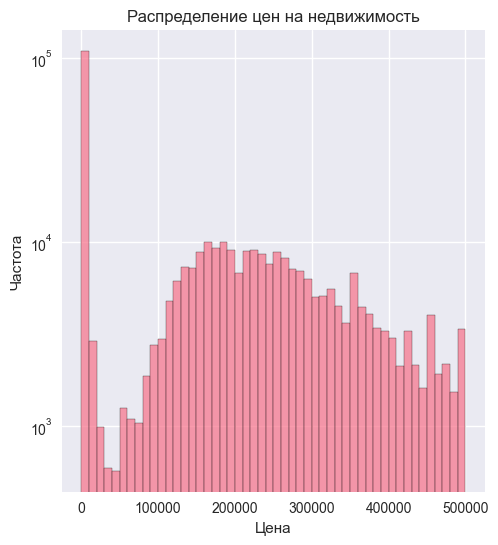

In [106]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение цен на недвижимость')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.yscale('log')

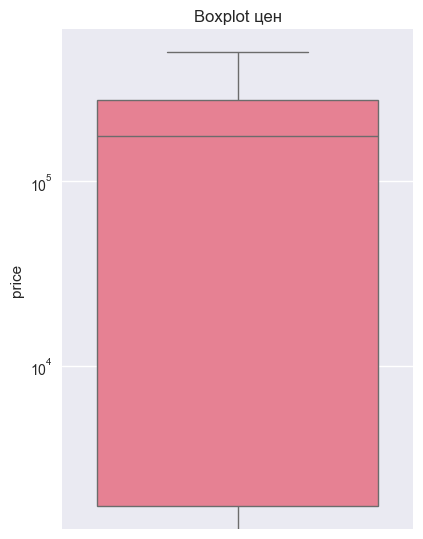

In [107]:
plt.subplot(1, 2, 2)
sns.boxplot(y=df['price'])
plt.title('Boxplot цен')
plt.yscale('log')
plt.tight_layout()
plt.show()

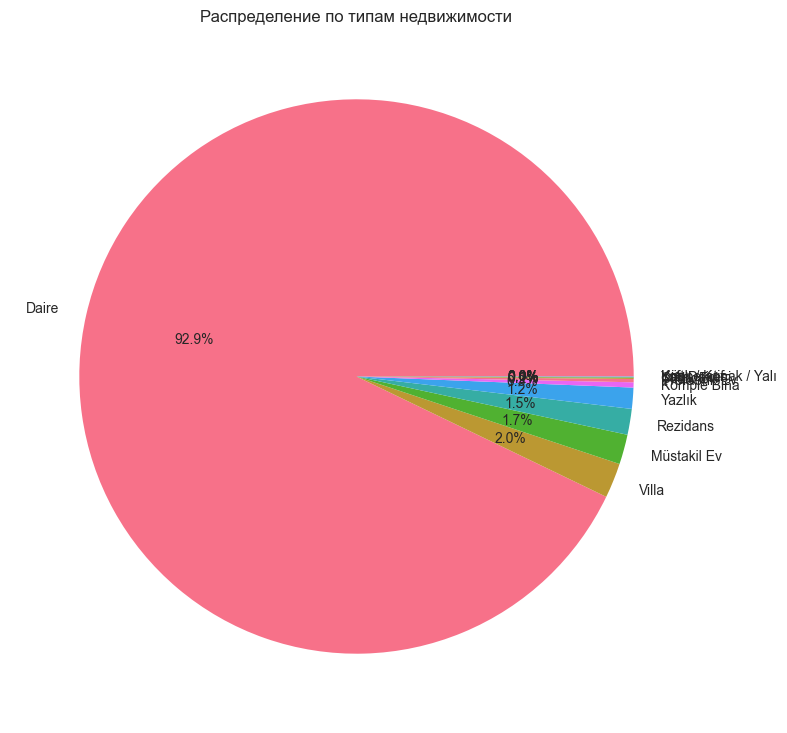

In [108]:
plt.figure(figsize=(14, 9))
sub_type_counts = df['sub_type'].value_counts()
plt.pie(sub_type_counts.values, labels=sub_type_counts.index, autopct='%1.1f%%')
plt.title('Распределение по типам недвижимости')
plt.show()

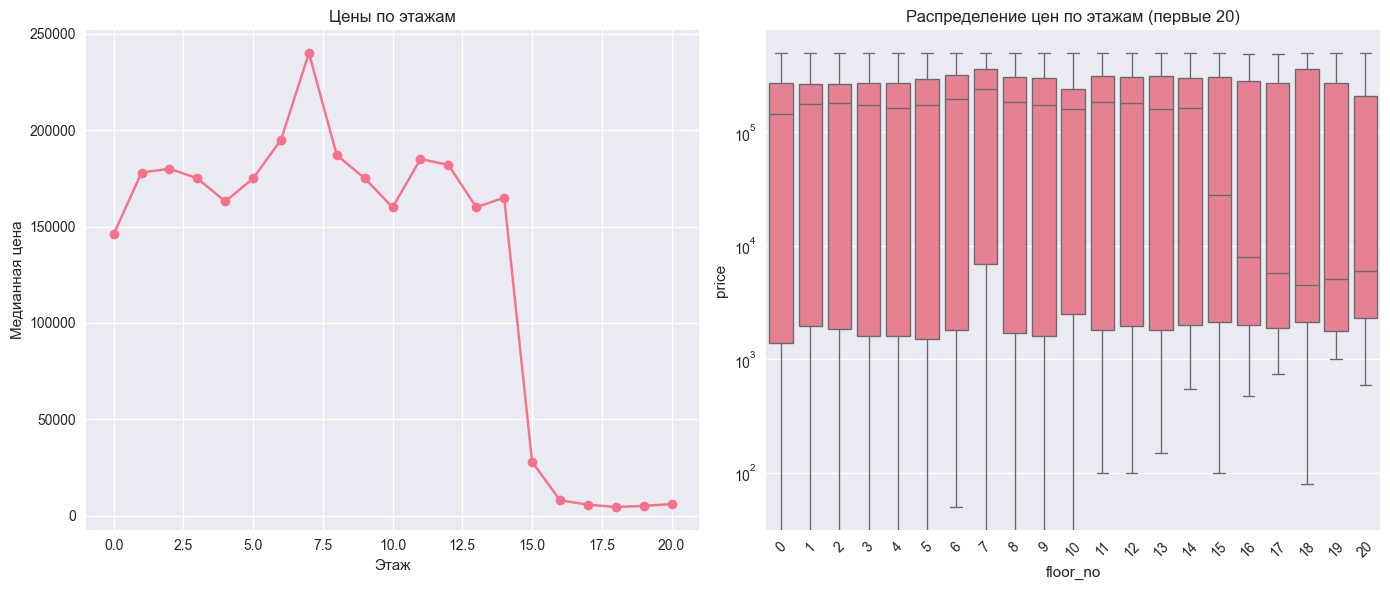

In [109]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
floor_price = df.groupby('floor_no')['price'].median()
plt.plot(floor_price.index, floor_price.values, marker='o')
plt.xlabel('Этаж')
plt.ylabel('Медианная цена')
plt.title('Цены по этажам')

plt.subplot(1, 2, 2)
sns.boxplot(x='floor_no', y='price', data=df[df['floor_no'] <= 20])
plt.yscale('log')
plt.title('Распределение цен по этажам (первые 20)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

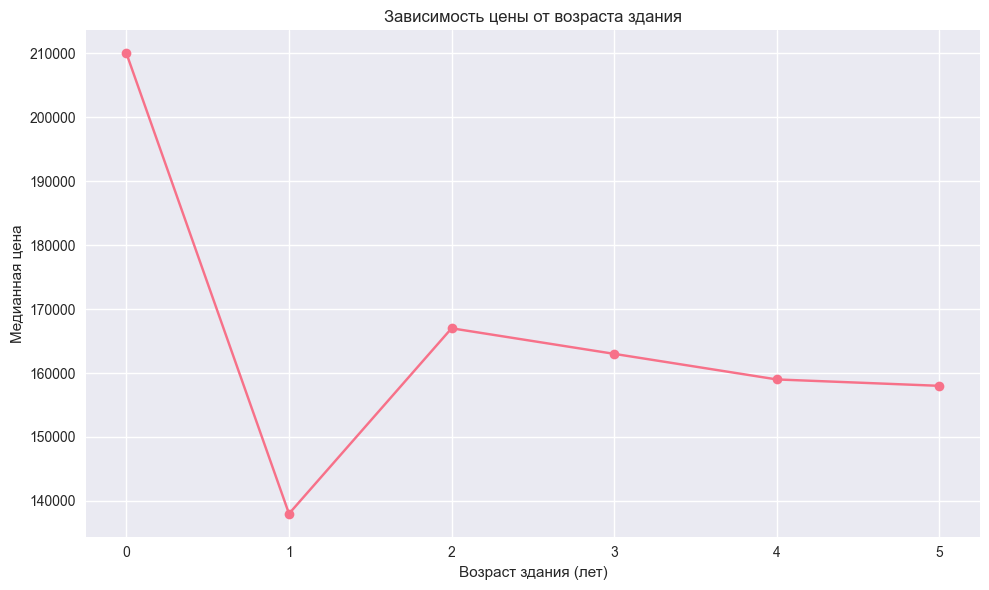

In [110]:
plt.figure(figsize=(10, 6))
building_age_price = df.groupby('building_age')['price'].median()
plt.plot(building_age_price.index, building_age_price.values, marker='o')
plt.xlabel('Возраст здания (лет)')
plt.ylabel('Медианная цена')
plt.title('Зависимость цены от возраста здания')
plt.tight_layout()
plt.show()

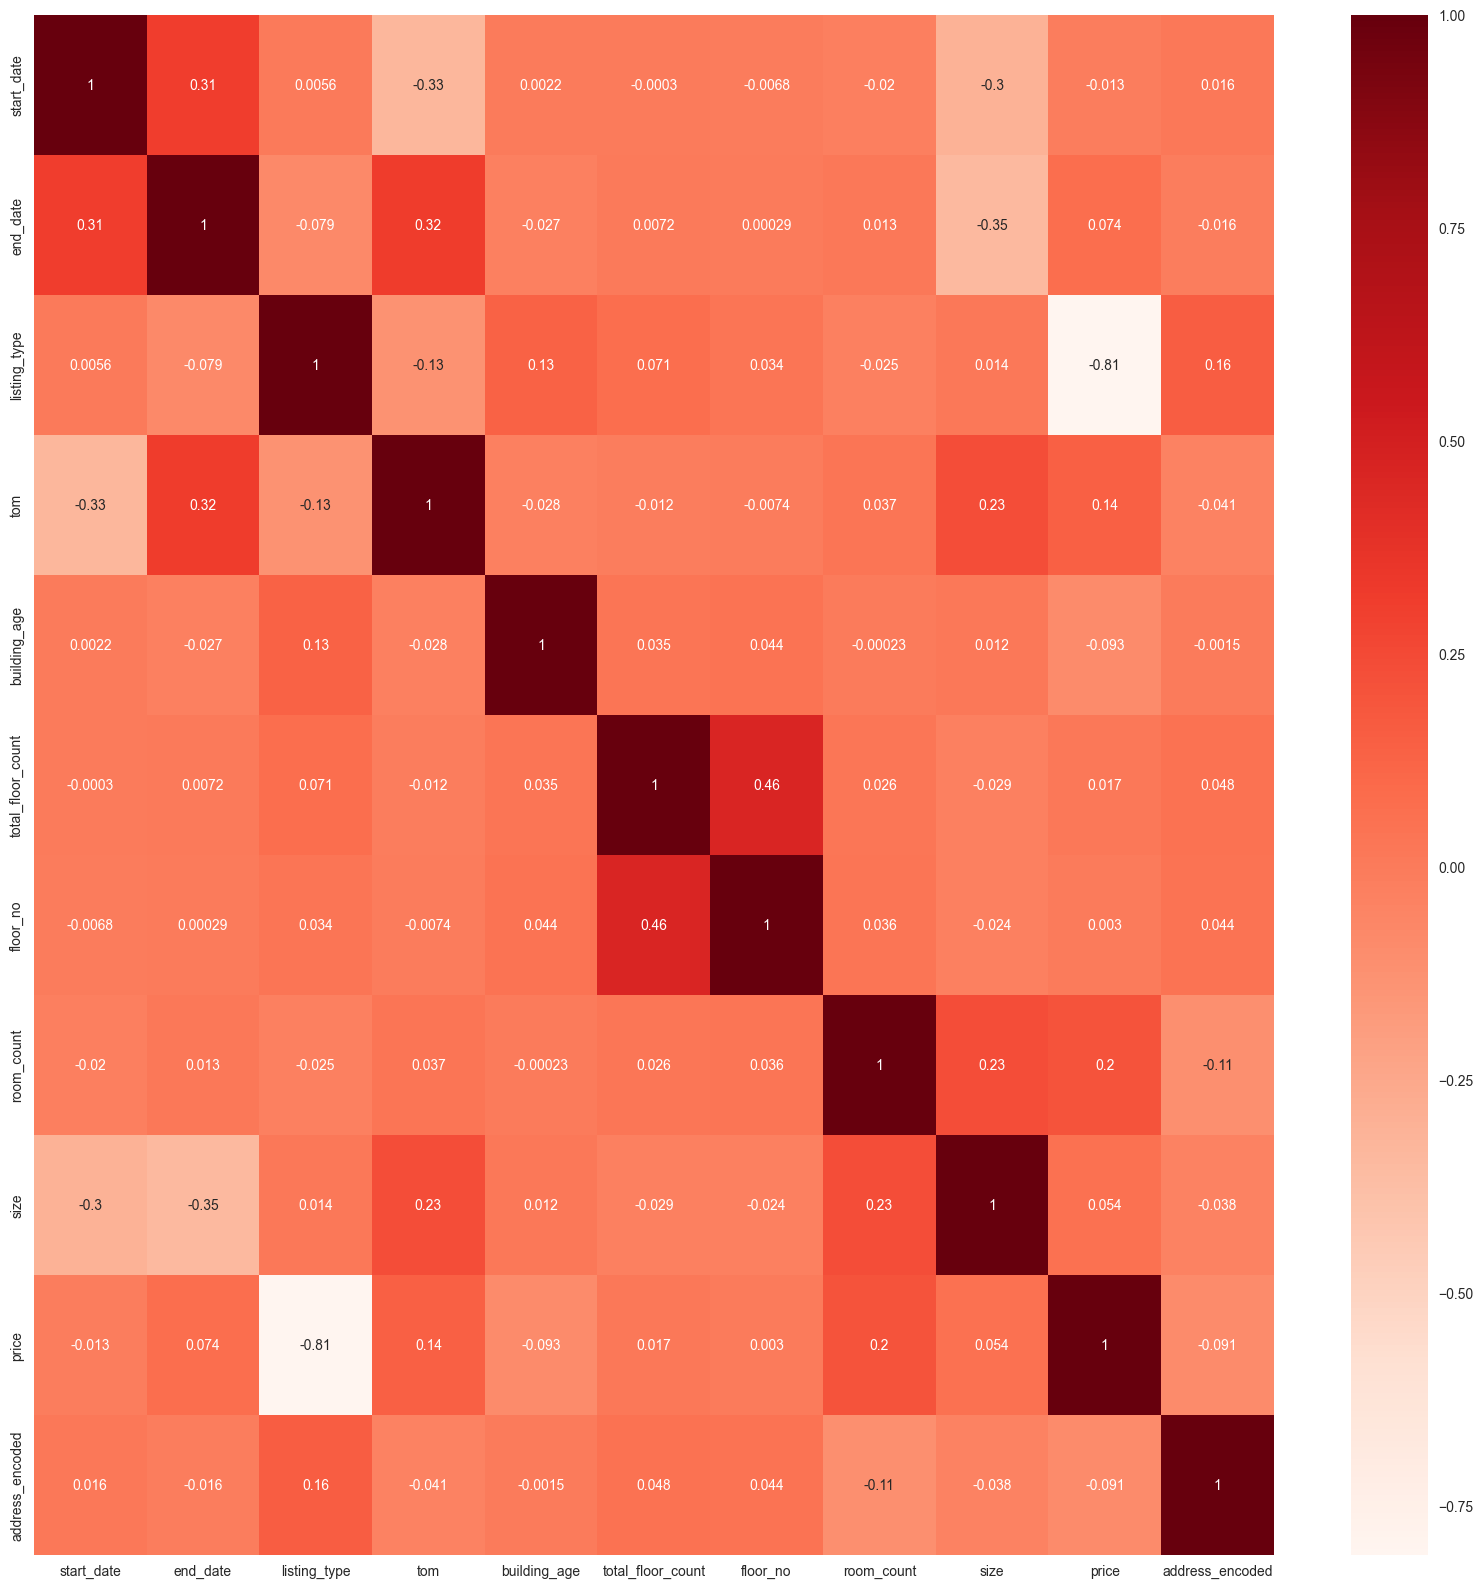

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

df_nums = df.select_dtypes(exclude=["object"])

plt.figure(figsize=(20, 20))
sns.heatmap(df_nums.corr(), annot=True, cmap='Reds')
plt.show()

In [112]:
df

,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,heating_type,price,address_encoded
0,Rezidans,2018-10-12,2019-01-09,2,30,0,20,2,3,90,Fancoil,3500.0,6301
1,Daire,2019-02-13,2018-12-27,1,14,0,20,20,1,43,Fancoil,490000.0,6301
2,Daire,2018-09-10,2018-11-08,1,30,0,1,10,3,279,Fancoil,155000.0,5314
6,Daire,2019-04-01,2018-12-27,2,54,0,20,14,4,160,Fancoil,3750.0,6301
11,Rezidans,2019-05-01,2019-01-18,2,13,2,20,20,4,165,Fancoil,7500.0,6703
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403480,Daire,2018-09-25,2019-01-23,1,120,1,0,0,4,279,absent,185000.0,1165
403481,Daire,2019-12-01,2018-12-27,1,46,1,0,0,1,279,absent,354641.0,7096
403482,Daire,2018-09-18,2018-12-27,2,162,1,0,0,1,279,absent,1500.0,6477
403483,Daire,2018-11-10,2018-12-27,1,139,1,0,0,3,279,absent,120000.0,4838


# Классификация 

In [113]:
#pip install catboost

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import StackingClassifier, BaggingClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score,mean_absolute_error,mean_squared_error,r2_score
from catboost import CatBoostClassifier,CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [115]:

df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])


df['start_year'] = df['start_date'].dt.year
df['start_month'] = df['start_date'].dt.month
df['start_day'] = df['start_date'].dt.day
df['end_year'] = df['end_date'].dt.year
df['end_month'] = df['end_date'].dt.month
df['end_day'] = df['end_date'].dt.day


df = df.drop(['start_date', 'end_date'], axis=1)

In [116]:
le = LabelEncoder()
df['heating_type_ecnoded'] = le.fit_transform(df['heating_type'])
df = df.drop('heating_type', axis=1)

In [117]:
# Целевая переменная
y = df['sub_type']
X = df.drop(['sub_type'], axis=1)

In [118]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [128]:
y = df['price']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Размеры данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Масштабирование признаков для лучшей производительности
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_state=42, verbose=0)
}

results = {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    
    print(f"R2 Score: {results[name]['R2']:.4f}")
    print(f"MAE: {results[name]['MAE']:.2f} TRY")
    print(f"RMSE: {results[name]['RMSE']:.2f} TRY")


print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
for name, metrics in results.items():
    print(f"{name}: R2={metrics['R2']:.4f}, MAE={metrics['MAE']:.0f} TRY, RMSE={metrics['RMSE']:.0f} TRY")

Размеры данных:
X_train: (277666, 16), y_train: (277666,)
X_test: (69417, 16), y_test: (69417,)

=== RandomForest ===
R2 Score: 1.0000
MAE: 0.62 TRY
RMSE: 9.60 TRY

=== GradientBoosting ===
R2 Score: 1.0000
MAE: 293.78 TRY
RMSE: 540.05 TRY

=== CatBoost ===
R2 Score: 0.9999
MAE: 965.28 TRY
RMSE: 1457.29 TRY

=== СРАВНЕНИЕ МОДЕЛЕЙ ===
RandomForest: R2=1.0000, MAE=1 TRY, RMSE=10 TRY
GradientBoosting: R2=1.0000, MAE=294 TRY, RMSE=540 TRY
CatBoost: R2=0.9999, MAE=965 TRY, RMSE=1457 TRY


# 1. CatBoosting

In [119]:
print("\n=== CatBoost ===")
catboost_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=0
)
catboost_clf.fit(X_train, y_train)
y_pred_catboost = catboost_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_catboost):.4f}")
print(classification_report(y_test, y_pred_catboost))



=== CatBoost ===
Accuracy: 0.9521
                     precision    recall  f1-score   support

              Daire       0.96      1.00      0.98     64457
        Komple Bina       0.98      0.53      0.69       211
         Kooperatif       0.00      0.00      0.00        12
Köşk / Konak / Yalı       0.00      0.00      0.00        16
               Loft       0.00      0.00      0.00         3
        Müstakil Ev       0.66      0.42      0.51      1206
       Prefabrik Ev       0.89      0.65      0.75       133
           Rezidans       0.75      0.17      0.27      1045
              Villa       0.65      0.61      0.63      1413
       Yalı Dairesi       0.00      0.00      0.00        20
             Yazlık       0.60      0.22      0.32       854
        Çiftlik Evi       1.00      0.02      0.04        47

           accuracy                           0.95     69417
          macro avg       0.54      0.30      0.35     69417
       weighted avg       0.94      0.95      0.

# 2. BaggingClassifier

In [120]:
print("=== BaggingClassifier ===")
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10),
    n_estimators=50,
    random_state=42
)
bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_bagging):.4f}")
print(classification_report(y_test, y_pred_bagging))

=== BaggingClassifier ===
Accuracy: 0.9532
                     precision    recall  f1-score   support

              Daire       0.97      1.00      0.98     64457
        Komple Bina       0.96      0.55      0.69       211
         Kooperatif       0.00      0.00      0.00        12
Köşk / Konak / Yalı       1.00      0.19      0.32        16
               Loft       0.00      0.00      0.00         3
        Müstakil Ev       0.64      0.46      0.54      1206
       Prefabrik Ev       0.74      0.67      0.70       133
           Rezidans       0.82      0.14      0.24      1045
              Villa       0.67      0.60      0.63      1413
       Yalı Dairesi       0.00      0.00      0.00        20
             Yazlık       0.56      0.31      0.40       854
        Çiftlik Evi       1.00      0.06      0.12        47

           accuracy                           0.95     69417
          macro avg       0.61      0.33      0.39     69417
       weighted avg       0.95      0.95

# 3. StackingClassifier

In [121]:
print("\n=== StackingClassifier ===")
# Базовые модели
base_models = [
    ('dt', DecisionTreeClassifier(max_depth=8, random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
]

# Мета-модель
meta_model = LogisticRegression(max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}")
print(classification_report(y_test, y_pred_stacking))


=== StackingClassifier ===
Accuracy: 0.9473
                     precision    recall  f1-score   support

              Daire       0.96      0.99      0.98     64457
        Komple Bina       0.93      0.51      0.66       211
         Kooperatif       0.00      0.00      0.00        12
Köşk / Konak / Yalı       0.00      0.00      0.00        16
               Loft       0.00      0.00      0.00         3
        Müstakil Ev       0.52      0.38      0.44      1206
       Prefabrik Ev       0.40      0.48      0.44       133
           Rezidans       0.78      0.13      0.22      1045
              Villa       0.55      0.61      0.58      1413
       Yalı Dairesi       0.00      0.00      0.00        20
             Yazlık       0.58      0.04      0.08       854
        Çiftlik Evi       0.00      0.00      0.00        47

           accuracy                           0.95     69417
          macro avg       0.39      0.26      0.28     69417
       weighted avg       0.94      0.

# Смотрим и выявляем лучшую модель

In [122]:
print("\n=== Сравнение моделей ===")
print(f"Bagging Accuracy: {accuracy_score(y_test, y_pred_bagging):.4f}")
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_pred_catboost):.4f}")
print(f"Stacking Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}")


=== Сравнение моделей ===
Bagging Accuracy: 0.9532
CatBoost Accuracy: 0.9521
Stacking Accuracy: 0.9473


In [123]:
import pickle

# Сохраняем модель
with open('bagging_clf.pkl', 'wb') as file:
    pickle.dump(bagging_clf, file)

# Выводы:

## В данной работе было проделано:
- подключение модулей
- загрузка данных
- разведочный анализ данных
- предварительная обработка данных
- визуальный анализ
- проведена классификация

## Итоги:
### Лучшая модель Bagging: 0.9